# Featuring engeneering


# Cargar datos e importar librerias

In [ ]:
#importar librerias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import joblib
import os



In [3]:
# Cargar datos
data_path = r'C:\Users\candy\Downloads\arkon_ds\data\bike_sharing_cleaned.csv'
df = pd.read_csv(data_path)

In [7]:
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351390 entries, 0 to 351389
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   trip_id              351390 non-null  int64  
 1   duration             351390 non-null  int64  
 2   start_time           351390 non-null  object 
 3   end_time             351390 non-null  object 
 4   start_lat            351390 non-null  float64
 5   start_lon            351390 non-null  float64
 6   end_lat              351390 non-null  float64
 7   end_lon              351390 non-null  float64
 8   bike_id              351390 non-null  float64
 9   plan_duration        351390 non-null  int64  
 10  trip_route_category  351390 non-null  object 
 11  passholder_type      351390 non-null  object 
 12  start_station        351390 non-null  int64  
 13  end_station          351390 non-null  int64  
 14  hour                 351390 non-null  int64  
 15  day_of_week      

(     trip_id  duration           start_time             end_time  start_lat  \
 0  101750280        35  2018-08-07 11:20:00  2018-08-07 11:55:00  33.748920   
 1  120016336         6  2019-04-22 09:22:00  2019-04-22 09:28:00  34.046070   
 2   63406498        30  2017-12-16 15:18:00  2017-12-16 15:48:00  34.135250   
 3   25033469        11  2017-04-15 22:02:00  2017-04-15 22:13:00  34.045181   
 4  107479459        15  2018-10-16 17:27:00  2018-10-16 17:42:00  34.041130   
 
     start_lon    end_lat     end_lon  bike_id  plan_duration  \
 0 -118.275192  33.748920 -118.275192   6530.0              1   
 1 -118.233093  34.047749 -118.243172   6710.0             30   
 2 -118.132370  34.135250 -118.132370   5768.0              0   
 3 -118.250237  34.053570 -118.266357   6527.0             30   
 4 -118.267982  34.045422 -118.253517   6333.0              1   
 
   trip_route_category passholder_type  start_station  end_station  hour  \
 0          Round Trip         Walk-up           4

# Preprocesamiento y featuring engeneering

In [8]:
# Convertir columnas de fecha a datetime
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])

# Manejo de valores nulos
df['bike_id'].fillna(df['bike_id'].mode()[0], inplace=True)
df['plan_duration'].fillna(df['plan_duration'].median(), inplace=True)

# Codificación de variables categóricas
le_route = LabelEncoder()
df['trip_route_category'] = le_route.fit_transform(df['trip_route_category'])

le_passholder = LabelEncoder()
df['passholder_type'] = le_passholder.fit_transform(df['passholder_type'])

# Crear variables de tiempo
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
df['time_of_day'] = pd.cut(df['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# One-hot encoding para time_of_day
df = pd.get_dummies(df, columns=['time_of_day'], drop_first=True)

# Función para calcular distancia entre estaciones (Haversine)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c  # Distancia en km

# Calcular distancia del trayecto
df['trip_distance_km'] = df.apply(lambda row: haversine(row['start_lat'], row['start_lon'], row['end_lat'], row['end_lon']), axis=1)

# Selección de variables
features = ['duration', 'plan_duration', 'trip_route_category', 'start_station',
            'end_station', 'hour', 'is_weekend', 'trip_distance_km',
            'time_of_day_Morning', 'time_of_day_Afternoon', 'time_of_day_Evening']
target = 'passholder_type'

X = df[features]
y = df[target]

# División en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalización
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Preprocesamiento completado 🎯")

C:\Users\candy\AppData\Local\Temp\ipykernel_14184\2838238215.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bike_id'].fillna(df['bike_id'].mode()[0], inplace=True)
C:\Users\candy\AppData\Local\Temp\ipykernel_14184\2838238215.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

Preprocesamiento completado 🎯


# Entrenar modelos

In [11]:
# Definir modelos a probar
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
    "XGBoost": xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Entrenar y evaluar modelos
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n🔹 Modelo: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    # Guardar modelo
    os.makedirs("../models", exist_ok=True)
    joblib.dump(model, f"../models/{name.lower().replace(' ', '_')}.pkl")
    print(f"Modelo guardado en: ../models/{name.lower().replace(' ', '_')}.pkl")



🔹 Modelo: Random Forest
Accuracy: 0.9440
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1864
           1       0.72      0.81      0.76      1683
           2       0.99      1.00      1.00     41070
           3       0.59      0.31      0.41      2858
           4       1.00      0.67      0.80         3
           5       0.91      0.95      0.93     22800

    accuracy                           0.94     70278
   macro avg       0.83      0.75      0.78     70278
weighted avg       0.94      0.94      0.94     70278

Modelo guardado en: ../models/random_forest.pkl

🔹 Modelo: Logistic Regression
Accuracy: 0.8716
              precision    recall  f1-score   support

           0       0.52      0.76      0.62      1864
           1       0.56      0.39      0.46      1683
           2       0.91      0.98      0.94     41070
           3       0.00      0.00      0.00      2858
           4       1.00      0.67      0.80     

C:\Users\candy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\candy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\candy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


🔹 Modelo: Gradient Boosting
Accuracy: 0.9362
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1864
           1       0.62      0.78      0.69      1683
           2       0.99      1.00      1.00     41070
           3       0.87      0.03      0.06      2858
           4       1.00      1.00      1.00         3
           5       0.89      0.97      0.93     22800

    accuracy                           0.94     70278
   macro avg       0.84      0.74      0.73     70278
weighted avg       0.94      0.94      0.92     70278

Modelo guardado en: ../models/gradient_boosting.pkl

🔹 Modelo: XGBoost
Accuracy: 0.9390
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1864
           1       0.67      0.81      0.74      1683
           2       0.99      1.00      1.00     41070
           3       0.72      0.03      0.06      2858
           4       1.00      1.00      1.00         

# Predicciones


🔹 Evaluación Random Forest
Accuracy: 0.9440
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1864
           1       0.72      0.81      0.76      1683
           2       0.99      1.00      1.00     41070
           3       0.59      0.31      0.41      2858
           4       1.00      0.67      0.80         3
           5       0.91      0.95      0.93     22800

    accuracy                           0.94     70278
   macro avg       0.83      0.75      0.78     70278
weighted avg       0.94      0.94      0.94     70278



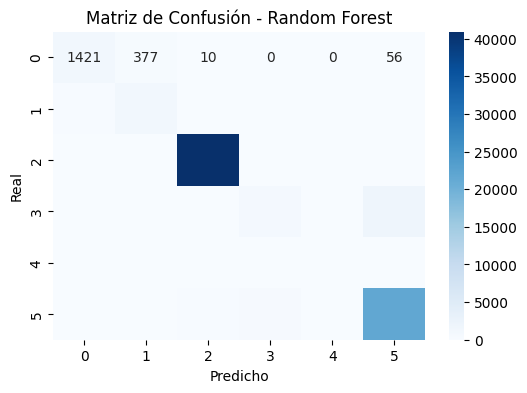

C:\Users\candy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\candy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\candy\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i


🔹 Evaluación Logistic Regression
Accuracy: 0.8716
              precision    recall  f1-score   support

           0       0.52      0.76      0.62      1864
           1       0.56      0.39      0.46      1683
           2       0.91      0.98      0.94     41070
           3       0.00      0.00      0.00      2858
           4       1.00      0.67      0.80         3
           5       0.85      0.83      0.84     22800

    accuracy                           0.87     70278
   macro avg       0.64      0.60      0.61     70278
weighted avg       0.84      0.87      0.85     70278



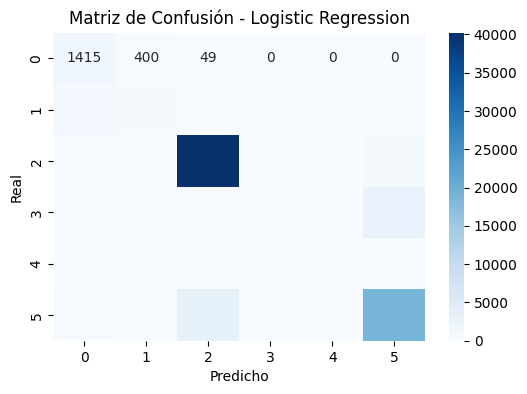


🔹 Evaluación Gradient Boosting
Accuracy: 0.9362
              precision    recall  f1-score   support

           0       0.69      0.67      0.68      1864
           1       0.62      0.78      0.69      1683
           2       0.99      1.00      1.00     41070
           3       0.87      0.03      0.06      2858
           4       1.00      1.00      1.00         3
           5       0.89      0.97      0.93     22800

    accuracy                           0.94     70278
   macro avg       0.84      0.74      0.73     70278
weighted avg       0.94      0.94      0.92     70278



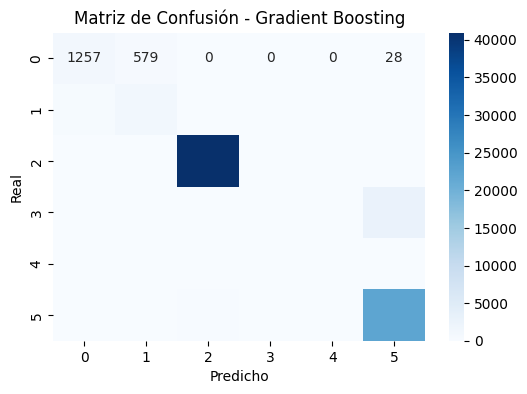


🔹 Evaluación Xgboost
Accuracy: 0.9390
              precision    recall  f1-score   support

           0       0.75      0.73      0.74      1864
           1       0.67      0.81      0.74      1683
           2       0.99      1.00      1.00     41070
           3       0.72      0.03      0.06      2858
           4       1.00      1.00      1.00         3
           5       0.89      0.97      0.93     22800

    accuracy                           0.94     70278
   macro avg       0.84      0.76      0.74     70278
weighted avg       0.93      0.94      0.92     70278



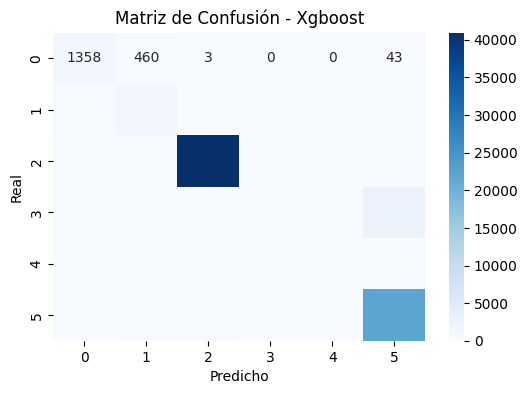

{'random_forest': 0.9439796237798458,
 'logistic_regression': 0.8715529753265603,
 'gradient_boosting': 0.9361962491818208,
 'xgboost': 0.9389567147613762}

In [13]:

# Lista de modelos a cargar
model_names = ["random_forest", "logistic_regression", "gradient_boosting", "xgboost"]
model_paths = {name: f"../models/{name}.pkl" for name in model_names}

# Diccionario para almacenar resultados
model_results = {}

# Evaluar cada modelo
for name, path in model_paths.items():
    try:
        # Cargar el modelo
        model = joblib.load(path)

        # Hacer predicciones
        y_pred = model.predict(X_test)

        # Evaluación
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Guardar resultados
        model_results[name] = {
            "accuracy": accuracy,
            "classification_report": report,
            "confusion_matrix": conf_matrix
        }

        # Imprimir métricas
        print(f"\n🔹 Evaluación {name.replace('_', ' ').title()}")
        print(f"Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))

        # Graficar matriz de confusión
        plt.figure(figsize=(6, 4))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicho")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusión - {name.replace('_', ' ').title()}")
        plt.show()

    except FileNotFoundError:
        print(f"⚠️ No se encontró el modelo: {path}")

# Mostrar comparaciones de accuracy entre modelos
model_comparisons = {name: result["accuracy"] for name, result in model_results.items()}
model_comparisons


In [15]:
df_train = pd.DataFrame(X_train, columns=features)
df_train['passholder_type'] = y_train.reset_index(drop=True)

df_test = pd.DataFrame(X_test, columns=features)
df_test['passholder_type'] = y_test.reset_index(drop=True)

df_train.to_csv("../data/train_preprocessed.csv", index=False)
df_test.to_csv("../data/test_preprocessed.csv", index=False)

print("Datos preprocesados guardados en data/ 🚀")


Datos preprocesados guardados en data/ 🚀
